### The Big Data Project
The goal for this project: The anaysis method and techniques used in the project can be appropriately applied to a real-world project.
### Weather Data For New York State

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

# _figsize=(10,7)


### Read Raw data for state

In [3]:
## read raw data from cloud (S3/AWS)
state='NY'
data_dir='../Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

%mkdir -p $data_dir
!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/NY.tgz > ../Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63.2M  100 63.2M    0     0  1945k      0  0:00:33  0:00:33 --:--:-- 3728k   0  0:00:48  0:00:08  0:00:40 2277k
-rw-r--r-- 1 ucsddse230 users 64M Sep  7 17:36 ../Data/Weather/NY.tgz


In [4]:
!ls $data_dir

NY.parquet  NY.tgz  stations.parquet  STAT_NY.pickle  Weather_Stations.tgz


In [5]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du ./$parquet
%cd $cur_dir

/home/ucsddse230/Data/Weather
77828	./NY.parquet
/home/ucsddse230/work


In [6]:
!du -h $data_dir/$parquet

77M	../Data/Weather/NY.parquet


In [7]:
print(parquet)
weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
#weather_df=weather_df.drop('State') # we drop State because it already exists in "Stations".

NY.parquet


In [8]:
print('number of rows=',weather_df.cache().count())
weather_df.show(5)

number of rows= 168398
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1948|[72 48 7A 48 85 4...|361.8320007324219|42.57080078125|-77.7133026123046

### Read information about US weather stations.

In [9]:
filename='Weather_Stations.tgz'
parquet='stations.parquet'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/Weather_Stations.tgz > ../Data/Weather/Weather_Stations.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  344k  100  344k    0     0   246k      0  0:00:01  0:00:01 --:--:--  246k


In [10]:
%cd $data_dir
!tar -xzf $filename
!du -s *.parquet
%cd $cur_dir

/home/ucsddse230/Data/Weather
77828	NY.parquet
420	stations.parquet
/home/ucsddse230/work


In [11]:
stations_df =sqlContext.read.parquet(data_dir+'/'+parquet)
stations_df.show(5)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
|USC00411974|   541.905| 31.5333|-101.2842|    755.9|   TX|        COPE RCH|
|USC00318906|   310.311| 35.5231| -81.4439|    274.3|   NC|    VALE AG 2 SW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 5 rows



In [12]:
weather_df=weather_df  #.drop('name').drop('dist_coast')
weather_df.show(3)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+---

In [13]:
## join the two datasets
jdf=weather_df.join(stations_df,on='Station',how='left')
jdf.show(3)
jdf.columns

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+----------+--------+---------+---------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|Dist_coast|Latitude|Longitude|Elevation|State|             Name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+----------+--------+---------+---------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|   361.832| 42.5708| -77.7133|    208.8|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|   361.832| 42.

['Station',
 'Measurement',
 'Year',
 'Values',
 'dist_coast',
 'latitude',
 'longitude',
 'elevation',
 'state',
 'name',
 'Dist_coast',
 'Latitude',
 'Longitude',
 'Elevation',
 'State',
 'Name']

In [15]:
##
sqlContext.registerDataFrameAsTable(weather_df,'jdf')

#find the stations in NY with the most measurements.
sqlContext.sql('select name,count(name) as count from jdf group by name order by count desc').show(5)
#GROUP BY name ORDER BY count').show(5)

+--------------------+-----+
|                name|count|
+--------------------+-----+
|     SETAUKET STRONG| 1438|
|NEW YORK CNTRL PK...| 1430|
|            LOWVILLE| 1410|
|              ELMIRA| 1408|
|            ANGELICA| 1406|
+--------------------+-----+
only showing top 5 rows



In [16]:
##
query='select * from jdf'
sqlContext.sql(query).show(5)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1948|[72 48 7A 48 85 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   

In [17]:
#find how many measurements of each type for a particlar station

stat='ELMIRA'    # location name
Query="""
SELECT Measurement,count(Measurement) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Measurement
"""%stat
sqlContext.sql(Query).show()

+-----------+-----+
|Measurement|count|
+-----------+-----+
|   TMIN_s20|  120|
|       TMIN|  120|
|   SNOW_s20|  121|
|       TOBS|  113|
|   SNWD_s20|  109|
|   TOBS_s20|  113|
|   PRCP_s20|  121|
|       TMAX|  120|
|       SNOW|  121|
|   TMAX_s20|  120|
|       SNWD|  109|
|       PRCP|  121|
+-----------+-----+



In [18]:
#find year with all 6 measurements
Query="""
SELECT Year,count(Year) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Year
ORDER BY count DESC
"""%stat
sqlContext.sql(Query).show(5)

+----+-----+
|Year|count|
+----+-----+
|1921|   12|
|1951|   12|
|1958|   12|
|1983|   12|
|1950|   12|
+----+-----+
only showing top 5 rows



In [19]:
# get all measurements for a particular year and a particular station

year=2007
stat='ELMIRA'    

Query="""
SELECT *
FROM jdf 
WHERE Name='%s' 
and Year=%d
"""%(stat,year )
pandas_df=sqlContext.sql(Query).toPandas()         
pandas_df=pandas_df.set_index('Measurement')
pandas_df

,Station,Year,Values,dist_coast,latitude,longitude,elevation,state,name
Measurement,,,,,,,,,
SNOW_s20,USC00302610,2007,"[102, 61, 227, 61, 128, 62, 17, 63, 170, 63, 7...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
SNWD_s20,USC00302610,2007,"[170, 70, 121, 71, 48, 72, 170, 72, 45, 73, 19...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TOBS_s20,USC00302610,2007,"[85, 203, 22, 204, 135, 204, 255, 204, 123, 20...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
PRCP_s20,USC00302610,2007,"[25, 76, 17, 76, 25, 76, 30, 76, 36, 76, 43, 7...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TMAX_s20,USC00302610,2007,"[79, 82, 17, 82, 214, 81, 149, 81, 83, 81, 15,...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TMIN_s20,USC00302610,2007,"[85, 209, 139, 209, 195, 209, 253, 209, 59, 21...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
PRCP,USC00302610,2007,"[0, 69, 0, 0, 0, 0, 0, 72, 128, 86, 0, 66, 112...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
SNOW,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
SNWD,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA


### Demonstrating plots

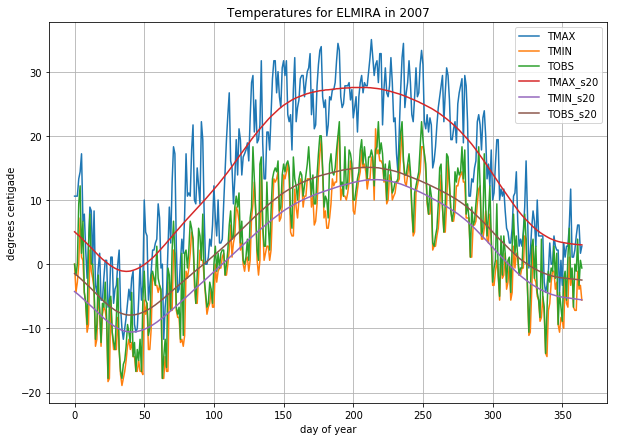

In [26]:
_tmax_20=unpackArray(pandas_df.loc['TMAX_s20','Values'],np.float16)/10.
_tmin_20=unpackArray(pandas_df.loc['TMIN_s20','Values'],np.float16)/10.
_tobs_20=unpackArray(pandas_df.loc['TOBS_s20','Values'],np.float16)/10.
_tmax=unpackArray(pandas_df.loc['TMAX','Values'],np.float16)/10.
_tmin=unpackArray(pandas_df.loc['TMIN','Values'],np.float16)/10.
_tobs=unpackArray(pandas_df.loc['TOBS','Values'],np.float16)/10.
figure(figsize=_figsize)
plot(_tmax,label='TMAX');
plot(_tmin,label='TMIN');
plot(_tobs,label='TOBS');

plot(_tmax_20,label='TMAX_s20');
plot(_tmin_20,label='TMIN_s20');
plot(_tobs_20,label='TOBS_s20');
xlabel('day of year')
ylabel('degrees centigade')
title('Temperatures for %s in %d'%(stat,year))
legend()
grid()

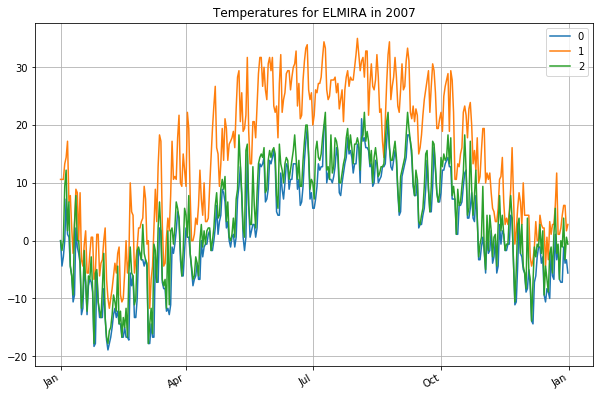

In [27]:
from lib.YearPlotter import YearPlotter
T=np.stack([_tmin,_tmax,_tobs])

fig, ax = plt.subplots(figsize=_figsize);
YP=YearPlotter()
YP.plot(T.transpose(),fig,ax,title='Temperatures for %s in %d'%(stat,year));
plt.savefig('percipitation.png')
#title('A sample of graphs');

In [24]:
## read statistics

filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/STAT_NY.pickle.gz > ../Data/Weather/STAT_NY.pickle.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.9M  100 29.9M    0     0   200k      0  0:02:33  0:02:33 --:--:--  162k 160k 61 18.4M    0     0   196k      0  0:02:35  0:01:35  0:01:00  139k


In [25]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath
!gunzip -f $gzpath

../Data/Weather/STAT_NY.pickle.gz
-rw-r--r-- 1 ucsddse230 users 31373293 Sep  7 17:55 ../Data/Weather/STAT_NY.pickle.gz


In [26]:
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'))
print('keys from STAT=',STAT.keys())

keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [27]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
SortedVals	                        Sample of values	vector whose length varies between measurements
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(365,)
        NE	                 count of values per day	(365,)
      Mean	                                    E/NE	(365,)
         O	                   Sum of outer products	(365, 365)
        NO	               counts for outer products	(365, 365)
       Cov	                

In [28]:
from lib.MultiPlot import *
from lib.YearPlotter import YearPlotter

YP=YearPlotter()
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,label=m)

In [29]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS','TMIN_s20','TMAX_s20','TOBS_s20']
    percipitation=['PRCP','SNOW','SNWD','PRCP_s20','SNOW_s20','SNWD_s20']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')

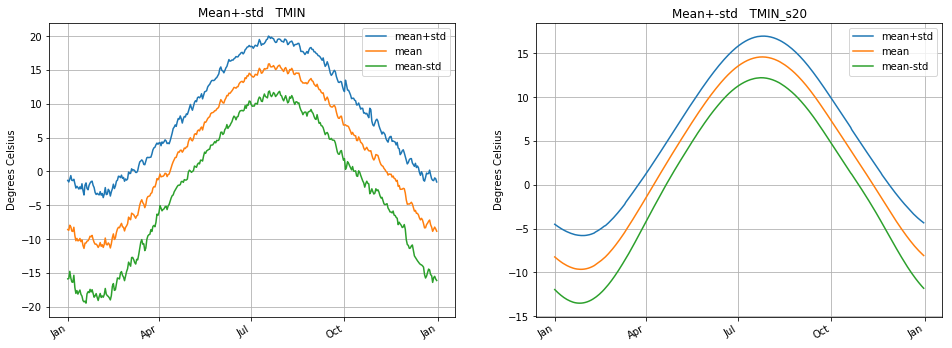

In [30]:
plot_pair(['TMIN','TMIN_s20'],plot_mean_std)

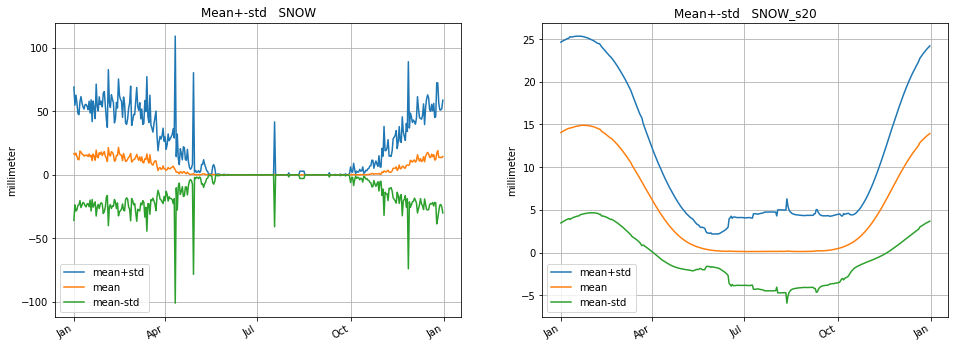

In [31]:
plot_pair(['SNOW', 'SNOW_s20'],plot_mean_std)